# Importing the libararies

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# For data cleaning and creating word embeddings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import pycountry

# # Loading the data
# df = pd.read_excel('Data.xlsx')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YUVRAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Grouping multiple datasets

In [2]:
# Let's load the train and test csv files from Kaggle folder and tsv files from the LIAR folder
kaggle_data = pd.read_csv('Datasets used/Kaggle dataset/train.csv')


# Let's load the train and test tsv files from LIAR folder
liar_test = pd.read_csv('Datasets used/LIAR dataset/test.tsv', delimiter='\t')
liar_train = pd.read_csv('Datasets used/LIAR dataset/train.tsv', delimiter='\t')
previous_data = pd.read_excel('Datasets used/Fake news challenge/Data.xlsx')
previous_data.columns = ['title','label']

In [3]:
# Extracting title and labels
kaggle_data = kaggle_data[['title','label']]

liar_train = liar_train[['Says the Annies List political group supports third-trimester abortions on demand.','false']]
liar_train.columns = ['title','label']

liar_test = liar_test[['Building a wall on the U.S.-Mexico border will take literally years.','true']]
liar_test.columns = ['title','label']

In [4]:
# Extracting only extreme labels
liar_train = liar_train[(liar_train['label'] == 'false') | (liar_train['label'] == 'true') | (liar_train['label'] == 'pants-fire')]
liar_test = liar_test[(liar_test['label'] == 'false') | (liar_test['label'] == 'true') | (liar_test['label'] == 'pants-fire')]

In [5]:
# Replacing pants fire with false
liar_train['label'] = liar_train['label'].replace({'pants-fire':'false'})
liar_test['label'] = liar_test['label'].replace({'pants-fire':'false'})

In [6]:
# Combining all the datasets 
df = pd.concat([kaggle_data,liar_train,liar_test,previous_data],axis=0)

# Dropping any duplicates
df.drop_duplicates(inplace=True)

In [7]:
# Storing the file 
df.to_excel('Data.xlsx', index=False)

# Exploratory data analysis

In [8]:
# Checking the shape of the dataframe
df.shape

(46696, 2)

In [14]:
# Checking first 5 rows of the dataframe
df.head(5)

,title,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,true
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",false
2,Why the Truth Might Get You Fired,true
3,15 Civilians Killed In Single US Airstrike Hav...,true
4,Iranian woman jailed for fictional unpublished...,true


Since we have combined multiple datasets thus in every dataset the names of labels could be different.

In [12]:
# Replacing 1 with true and 0 with false
df['label'] = df['label'].replace({1: 'true', 0: 'false'})

In [15]:
# Let's check the datatype of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46696 entries, 0 to 43994
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   46695 non-null  object
 1   label   46696 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [16]:
# Checking any null values
df.isnull().mean()*100

title    0.002142
label    0.000000
dtype: float64

In [17]:
# Checking any duplicated values
df.duplicated().sum()

0

<AxesSubplot:ylabel='label'>

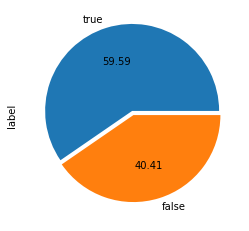

In [19]:
# Let's check distribution of data across both classes in the target variable
ex = (0.05, 0)
df['label'].value_counts().plot(kind='pie',autopct='%.2f',explode= ex)

# Data cleaning 

- Handling missing values
- Lowercasing
- Punctuation removal
- Stop word removal
- Spelling check
- Stemming/lemmatization

Since title is a feature having long sentences in it, thus the imputation techniques will be little modified.

1. Fill missing values with a placeholder: One simple approach is to fill the missing values with a placeholder such as NA or missing. This approach can be useful if you want to retain the structure of the original text data and still be able to identify the missing values. However, it's important to ensure that the placeholder does not occur naturally in the text data.

2. Impute missing values using statistical techniques: You can use statistical techniques such as mean or mode imputation to fill in missing values. For example, you could compute the average length of the sentences in the feature and use this value to fill in the missing values.

3. Impute missing values using machine learning models: You can use machine learning models such as regression or clustering to impute missing values based on the patterns in the other features. For example, you could train a regression model to predict the length of the sentences in the feature based on the values in other features, and then use this model to impute missing values.

4. Use natural language processing techniques: You can use natural language processing techniques such as language models or topic models to impute missing values based on the context of the text data. For example, you could use a language model to generate plausible sentences that fit the context of the text data and use these sentences to fill in the missing values.

In [ ]:
# Since title have some null values in it so we will simply remove them


In [9]:
# Let's remove duplicated values form the dataframe
df.drop_duplicates(inplace=True)

# Removing the missing titles
df.dropna(inplace=True)

In [11]:
# let's crete an object of WordNetLemmatizer class for doing lemmatization
lemm = WordNetLemmatizer()

# Empty list to store the clean title
cleaned_data = []
for i in df['title']:
    cleaned_title = re.sub('[^a-zA-Z]',' ',str(i)) # Removal of punctuations
    cleaned_title = cleaned_title.split() # Tokenization
    
    # create a set of country names using the pycountry library
    countries = set([country.name.lower() for country in pycountry.countries])
    
    cleaned_title = [word.lower() if word.lower() not in countries else word for word in cleaned_title] # lowering the words except country names
    
    # Stopword removal and lemmatizatoin
    cleaned_title = [lemm.lemmatize(word) for word in cleaned_title if not word in stopwords.words('english')]
    cleaned_title = ' '.join(cleaned_title)
    cleaned_data.append(cleaned_title)

In [14]:
# Let's now format the data for the Word2Vec Model
cleaned_Data = []
for text in cleaned_data:
    cleaned_Data.append(simple_preprocess(text))

# Creating word embeddings

In [16]:
# create a Word2Vec model and build the vocabulary
model = Word2Vec(window=5, min_count=1, workers=4)
model.build_vocab(cleaned_Data)

In [17]:
model.train(cleaned_Data, total_examples=model.corpus_count, epochs=model.epochs)

(1618722, 1721905)

In [23]:
# Let's reduce the dimensions
pca = PCA(n_components=3)

In [24]:
X = pca.fit_transform(model.wv.get_normed_vectors())

# Model training

# Model evaluation